In [1]:
import tensorly as tl
import tlquantum as tlq
import torch
from tensorly.tt_matrix import TTMatrix
from torch import randint, rand, arange, complex64
from torch.optim import Adam
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import numpy as np
from IPython.display import clear_output

In [2]:
def get_param_vector(parameters):
    
    param_vector = []

    for param in parameters:
        param_vector.append(param.detach().numpy())

        #print(param.detach().numpy())

    param_vector = np.asarray(param_vector).reshape(1,-1)[0]
    return param_vector

In [55]:
# Building a trial 3 qubit circuit

ncontraq = 2
ncontral = 2
nqubits = 4
dtype = complex64
device = 'cpu'

state = tlq.spins_to_tt_state([1 for i in range(nqubits)], device=device, dtype=dtype) # generate generic zero state |00000>
state = tlq.qubits_contract(state, ncontraq)

# print(state.to_ket())

CZ_list = [tlq.tt_gates.IDENTITY(dtype , device), tlq.tt_gates.CZR(dtype , device),tlq.tt_gates.IDENTITY(dtype , device), tlq.tt_gates.CZL(dtype , device) ]

CZ_gate = tlq.Unitary(CZ_list, nqubits, ncontraq)


circuit = tlq.tt_circuit.TTCircuit([CZ_gate], ncontraq, ncontral)

# iden_list = [tlq.tt_gates.IDENTITY(), tlq.tt_gates.IDENTITY(), tlq.tt_gates.IDENTITY()]
# Iden_gate = tlq.Unitary(iden_list, 3, ncontraq)

# circuit = tlq.tt_circuit.TTCircuit([Iden_gate], ncontraq, ncontral)

circuit.to_ket(state)

# circuit.to_operator()




tensor([[0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j],
        [0.+0.j]])

In [78]:
ncontraq = 2
ncontral = 2
nqubits = 3
dtype = complex64
device = 'cpu'

state = tlq.spins_to_tt_state([1 for i in range(nqubits)], device=device, dtype=dtype) 
state = tlq.qubits_contract(state, ncontraq)

print(f"Initial state (Z basis): {[1 for i in range(nqubits)]}")
print("################################################################")


for control_qubit in range(nqubits-1):
    CZ_gate_list = []
    for qubit in range(nqubits-1):
        if qubit == control_qubit:
            CZ_gate_list.append(tlq.tt_gates.CZR(dtype , device))
        else:
            CZ_gate_list.append(tlq.tt_gates.IDENTITY(dtype , device))

    CZ_gate_list.append(tlq.tt_gates.CZL(dtype , device))
    CZ_gate = tlq.Unitary(CZ_gate_list, nqubits, ncontraq)

    circuit = tlq.tt_circuit.TTCircuit([CZ_gate], ncontraq, ncontral)

    print(f"Applied unitary: {CZ_gate_list}")

    print(f"Matrix representation: {circuit.to_operator().numpy()})")
    print(f"Final ket: {circuit.to_ket(state)}")
    print("################################################################")



Initial state (Z basis): [1, 1, 1]
################################################################
Applied unitary: [CZR(), IDENTITY(), CZL()]
Matrix representation: [[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j -1.+0.j]])
Final ket: tensor([[ 0.+0.j],
        [ 0.+0.j],
        [ 0.+0.j],
        [ 0.+0.j],
        [ 0.+0.j],
        [ 0.+0.j],
        [ 0.+0.j],
        [-1.+0.j]])
################################################################
Applied unitary: [IDENTITY(), CZR(), CZL()]
Matrix representation:

In [5]:
def run_experiment(nqubits, layers, nepochs, repetitions, h_parameter):
    
    #device = 'cuda'
    device = 'cpu'

    dtype = complex64

    #nepochs = 80 #number of training epochs
    #repetitions = 40

    #nqubits = 5 #number of qubits
    ncontraq = 2 #2 #number of qubits to pre-contract into single core
    ncontral = 2 #2 #number of layers to pre-contract into a single core
    # nterms = 10 # What does this mean?
    lr = 0.5 # learning rate

    all_parameter_trajectories=[]
    all_costs = []

    for k in range(repetitions):

        state = tlq.spins_to_tt_state([0 for i in range(nqubits)], device=device, dtype=dtype) # generate generic zero state |00000>
        state = tlq.qubits_contract(state, ncontraq)

        # what is going on here?
        qubits1 = torch.tensor([i for i in range(nqubits-1)])
        qubits2 = torch.tensor([i for i in range(1,nqubits)])
        qubits2[qubits2==qubits1] += 1
        qubits2[qubits2 >= nqubits] = 0

        #weights = rand((nterms,), device=device) # randomly generated coefficients of each two-qubit interaction in Hamiltonian
        weights = tl.ones(nqubits)

        binary_H = tlq.binary_hamiltonian(tlq.pauli_z(device=device, dtype=dtype), nqubits, qubits1, qubits2, weights) # build the spin-spin Hamiltonian H

        qubits = arange(nqubits, device=device) # specify that each qubit will have a transverse field term
        #weights = rand((nqubits,), device=device) # randomly generated coefficients for the transverse field felt by each qubit

        weights = h_parameter*tl.ones(nqubits) # Nicer Hamiltonian domain

        unary_H = tlq.unary_hamiltonian(tlq.pauli_x(device=device, dtype=dtype), nqubits, qubits, weights) #build the transverse field Hamiltonian

        Ising_H = tlq.tt_matrix_sum(binary_H, unary_H)

        #custom_U = tlq.Unitary([tlq.RotY(device=device, dtype=dtype), *tlq.so4(0,1, device=device, dtype=dtype), tlq.RotY(device=device, dtype=dtype), *tlq.so4(2, 3, device=device, dtype=dtype)], nqubits, ncontraq)

        RotX1 = tlq.UnaryGatesUnitary(nqubits, ncontraq, axis='x', device=device, dtype=dtype) # one Y-axis rotation gate applied to each qubit of the circuit
        RotZ1 = tlq.UnaryGatesUnitary(nqubits, ncontraq, axis='z', device=device, dtype=dtype)
        RotX2 = tlq.UnaryGatesUnitary(nqubits, ncontraq, axis='x', device=device, dtype=dtype) # one Y-axis rotation gate applied to each qubit of the circuit
        RotZ2 = tlq.UnaryGatesUnitary(nqubits, ncontraq, axis='z', device=device, dtype=dtype)
        #RotX = tlq.UnaryGatesUnitary(nqubits, ncontraq, axis='x', device=device, dtype=dtype)
        parity = 0 # WHY DOES THIS MATTER?
        CZ0 = tlq.BinaryGatesUnitary(nqubits, ncontraq, tlq.cz(device=device, dtype=dtype), parity) # one controlled-z gate for each pair of qubits using even parity (even qubits control)
        
        # creating the CZ layer:


        

        #parity = 1
        #SO4_01 = tlq.BinaryGatesUnitary(nqubits, ncontraq, tlq.so4(2,3, device=device, dtype=dtype), parity) # one SO4 rotation about two-qubit states |2> and |3> with odd parity

        unitaries = [RotX1, RotZ1, CZ0, RotX2, RotZ2]
        loss_unitaries = copy.deepcopy(unitaries)

        repeat_block, unitaries_automatic = layers, []
        for i in range(repeat_block):
           unitaries_automatic += unitaries

        circuit = tlq.TTCircuit(unitaries_automatic, ncontraq, ncontral)
        opt = Adam(circuit.parameters(), lr=lr, amsgrad=True) # define PyTorch optimizer
        # energy_vec = tl.zeros(nepochs)


        print("Starting experiment "+ str(k))

        param_trajectory = []
        #param_tensors = []
        costs = []

        # update parameter history for 0th iteration
        # param_trajectory.append(get_param_vector(circuit.parameters()))
        # param_tensors.append(circuit.parameters())


        for epoch in tqdm(range(nepochs)):
            # TTCircuit forward pass computes expectation value of Ising_H
            energy = circuit.forward_expectation_value(state, Ising_H)
            param_trajectory.append(get_param_vector(circuit.parameters()))
            #energy_tensor, energy = calculate_energy(circuit,state,Ising_H)

            costs.append(energy[0].item())
            # energy_vec[epoch] = energy
            #print('Energy (loss) at epoch ' + str(epoch) + ' is ' + str(energy[0].item()) + '. \n')
            #print(list(circuit.parameters()))

            # PyTorch Autograd attends to backwards pass and parameter update
            #energy_tensor.backward() # Computes gradient of energy tensor
            energy.backward()

            opt.step() #performs optimization step on circuit.parameters

            # update parameter history
            #param_trajectory.append(get_param_vector(circuit.parameters()))
            #param_tensors.append(circuit.parameters())
            opt.zero_grad(epoch) #Setting grad to zero? not sure




        all_parameter_trajectories.append(np.asarray(param_trajectory))
        all_costs.append(np.asarray(costs))
        
        
        
    # Defining the loss function for each circuit
    loss_circuit = tlq.TTCircuit(loss_unitaries, ncontraq, ncontral)

    def loss_function(params):

        for loss_circuit_param, param in zip(loss_circuit.parameters(), params):

            loss_circuit_param.data.fill_(param)

            

        return np.real(loss_circuit.forward_expectation_value(state, Ising_H)[0].item())
    
    
    return all_parameter_trajectories, all_costs, loss_function


In [7]:
%%time

experiments = [
    {
      "qubits": 4,
      "layers": 4,
      "repetitions": 100,
        "h": 0.0
    },
    {
      "qubits": 4,
      "layers": 4,
      "repetitions": 100,
        "h": 0.1
    },
    {
      "qubits": 6,
      "layers": 6,
      "repetitions": 100,
        "h": 0.0
    },
    {
      "qubits": 6,
      "layers": 6,
      "repetitions": 100,
        "h": 0.1
    },
    {
      "qubits": 8,
      "layers": 8,
      "repetitions": 100,
        "h": 0.0
    },
    {
      "qubits": 8,
      "layers": 8,
      "repetitions": 100,
        "h": 0.1
    },
]

for experiment in experiments:
    
    print(experiment)
    
    all_parameter_trajectories, all_costs, loss_function = run_experiment(experiment["qubits"], experiment["layers"], 150, experiment["repetitions"], experiment["h"])
    
    # ordering the arrays to plot histogram
    all_parameter_trajectories = np.array(all_parameter_trajectories)
    all_final_parameters = all_parameter_trajectories[:,-1]
    all_costs = np.array(all_costs)

    sorted_indices = np.argsort(all_costs[:,-1])
    all_parameter_trajectories = all_parameter_trajectories[sorted_indices]
    all_final_parameters = all_parameter_trajectories[:,-1]
    all_costs = all_costs[sorted_indices]
    
    
    experiment["all_parameters"] = all_parameter_trajectories
    experiment["all_final_parameters"] = all_final_parameters
    experiment["all_costs"] = all_costs
    experiment["loss_function"] = loss_function
    
    clear_output(wait=True)
    
    
    
    #all_parameter_trajectories, all_costs, loss_function = run_experiment(5, 5, 80, 40)
    

{'qubits': 6, 'layers': 6, 'repetitions': 100, 'h': 0.0}
Starting experiment 0


100%|██████████| 150/150 [00:04<00:00, 36.69it/s]


Starting experiment 1


100%|██████████| 150/150 [00:04<00:00, 37.18it/s]


Starting experiment 2


100%|██████████| 150/150 [02:30<00:00,  1.00s/it]


Starting experiment 3


100%|██████████| 150/150 [00:04<00:00, 37.28it/s]


Starting experiment 4


100%|██████████| 150/150 [00:57<00:00,  2.59it/s]


Starting experiment 5


100%|██████████| 150/150 [00:04<00:00, 37.06it/s]


Starting experiment 6


100%|██████████| 150/150 [00:04<00:00, 37.32it/s]


Starting experiment 7


100%|██████████| 150/150 [01:13<00:00,  2.03it/s]


Starting experiment 8


100%|██████████| 150/150 [00:04<00:00, 36.33it/s]


Starting experiment 9


100%|██████████| 150/150 [01:24<00:00,  1.78it/s]


Starting experiment 10


100%|██████████| 150/150 [00:08<00:00, 17.48it/s]


Starting experiment 11


100%|██████████| 150/150 [00:06<00:00, 22.14it/s]


Starting experiment 12


100%|██████████| 150/150 [00:04<00:00, 34.39it/s]


Starting experiment 13


100%|██████████| 150/150 [00:04<00:00, 35.27it/s]


Starting experiment 14


100%|██████████| 150/150 [00:04<00:00, 35.05it/s]


Starting experiment 15


100%|██████████| 150/150 [00:04<00:00, 31.95it/s]


Starting experiment 16


100%|██████████| 150/150 [00:05<00:00, 27.29it/s]


Starting experiment 17


100%|██████████| 150/150 [00:04<00:00, 33.30it/s]


Starting experiment 18


100%|██████████| 150/150 [00:04<00:00, 32.54it/s]


Starting experiment 19


100%|██████████| 150/150 [00:04<00:00, 32.30it/s]


Starting experiment 20


100%|██████████| 150/150 [00:06<00:00, 24.54it/s]


Starting experiment 21


100%|██████████| 150/150 [00:04<00:00, 31.02it/s]


Starting experiment 22


100%|██████████| 150/150 [00:05<00:00, 26.87it/s]


Starting experiment 23


100%|██████████| 150/150 [00:04<00:00, 31.41it/s]


Starting experiment 24


100%|██████████| 150/150 [00:04<00:00, 33.89it/s]


Starting experiment 25


100%|██████████| 150/150 [00:04<00:00, 34.58it/s]


Starting experiment 26


100%|██████████| 150/150 [00:04<00:00, 33.34it/s]


Starting experiment 27


100%|██████████| 150/150 [00:04<00:00, 32.10it/s]


Starting experiment 28


100%|██████████| 150/150 [00:05<00:00, 29.02it/s]


Starting experiment 29


100%|██████████| 150/150 [00:04<00:00, 34.47it/s]


Starting experiment 30


100%|██████████| 150/150 [00:04<00:00, 36.13it/s]


Starting experiment 31


100%|██████████| 150/150 [00:04<00:00, 35.93it/s]


Starting experiment 32


100%|██████████| 150/150 [00:04<00:00, 37.03it/s]


Starting experiment 33


100%|██████████| 150/150 [00:04<00:00, 33.12it/s]


Starting experiment 34


100%|██████████| 150/150 [00:04<00:00, 34.71it/s]


Starting experiment 35


100%|██████████| 150/150 [00:04<00:00, 35.06it/s]


Starting experiment 36


100%|██████████| 150/150 [00:04<00:00, 35.27it/s]


Starting experiment 37


100%|██████████| 150/150 [00:04<00:00, 36.86it/s]


Starting experiment 38


100%|██████████| 150/150 [00:04<00:00, 37.10it/s]


Starting experiment 39


100%|██████████| 150/150 [00:04<00:00, 36.97it/s]


Starting experiment 40


100%|██████████| 150/150 [00:04<00:00, 36.66it/s]


Starting experiment 41


100%|██████████| 150/150 [00:04<00:00, 33.07it/s]


Starting experiment 42


100%|██████████| 150/150 [00:04<00:00, 35.42it/s]


Starting experiment 43


100%|██████████| 150/150 [00:04<00:00, 36.89it/s]


Starting experiment 44


100%|██████████| 150/150 [00:04<00:00, 35.55it/s]


Starting experiment 45


100%|██████████| 150/150 [00:04<00:00, 35.93it/s]


Starting experiment 46


100%|██████████| 150/150 [00:04<00:00, 35.52it/s]


Starting experiment 47


100%|██████████| 150/150 [00:04<00:00, 37.18it/s]


Starting experiment 48


100%|██████████| 150/150 [00:04<00:00, 37.07it/s]


Starting experiment 49


100%|██████████| 150/150 [00:04<00:00, 37.08it/s]


Starting experiment 50


100%|██████████| 150/150 [00:04<00:00, 30.62it/s]


Starting experiment 51


100%|██████████| 150/150 [00:04<00:00, 36.92it/s]


Starting experiment 52


100%|██████████| 150/150 [00:04<00:00, 36.88it/s]


Starting experiment 53


100%|██████████| 150/150 [00:04<00:00, 36.65it/s]


Starting experiment 54


100%|██████████| 150/150 [00:04<00:00, 37.07it/s]


Starting experiment 55


100%|██████████| 150/150 [00:05<00:00, 27.46it/s]


Starting experiment 56


100%|██████████| 150/150 [00:04<00:00, 36.72it/s]


Starting experiment 57


100%|██████████| 150/150 [00:04<00:00, 35.98it/s]


Starting experiment 58


100%|██████████| 150/150 [00:04<00:00, 34.66it/s]


Starting experiment 59


100%|██████████| 150/150 [00:04<00:00, 32.86it/s]


Starting experiment 60


100%|██████████| 150/150 [00:04<00:00, 35.08it/s]


Starting experiment 61


100%|██████████| 150/150 [00:04<00:00, 35.43it/s]


Starting experiment 62


100%|██████████| 150/150 [00:04<00:00, 36.29it/s]


Starting experiment 63


100%|██████████| 150/150 [00:04<00:00, 34.82it/s]


Starting experiment 64


100%|██████████| 150/150 [00:04<00:00, 36.18it/s]


Starting experiment 65


100%|██████████| 150/150 [00:04<00:00, 36.58it/s]


Starting experiment 66


100%|██████████| 150/150 [00:05<00:00, 29.04it/s]


Starting experiment 67


100%|██████████| 150/150 [00:07<00:00, 20.70it/s]


Starting experiment 68


 84%|████████▍ | 126/150 [00:07<00:01, 16.04it/s]


KeyboardInterrupt: 

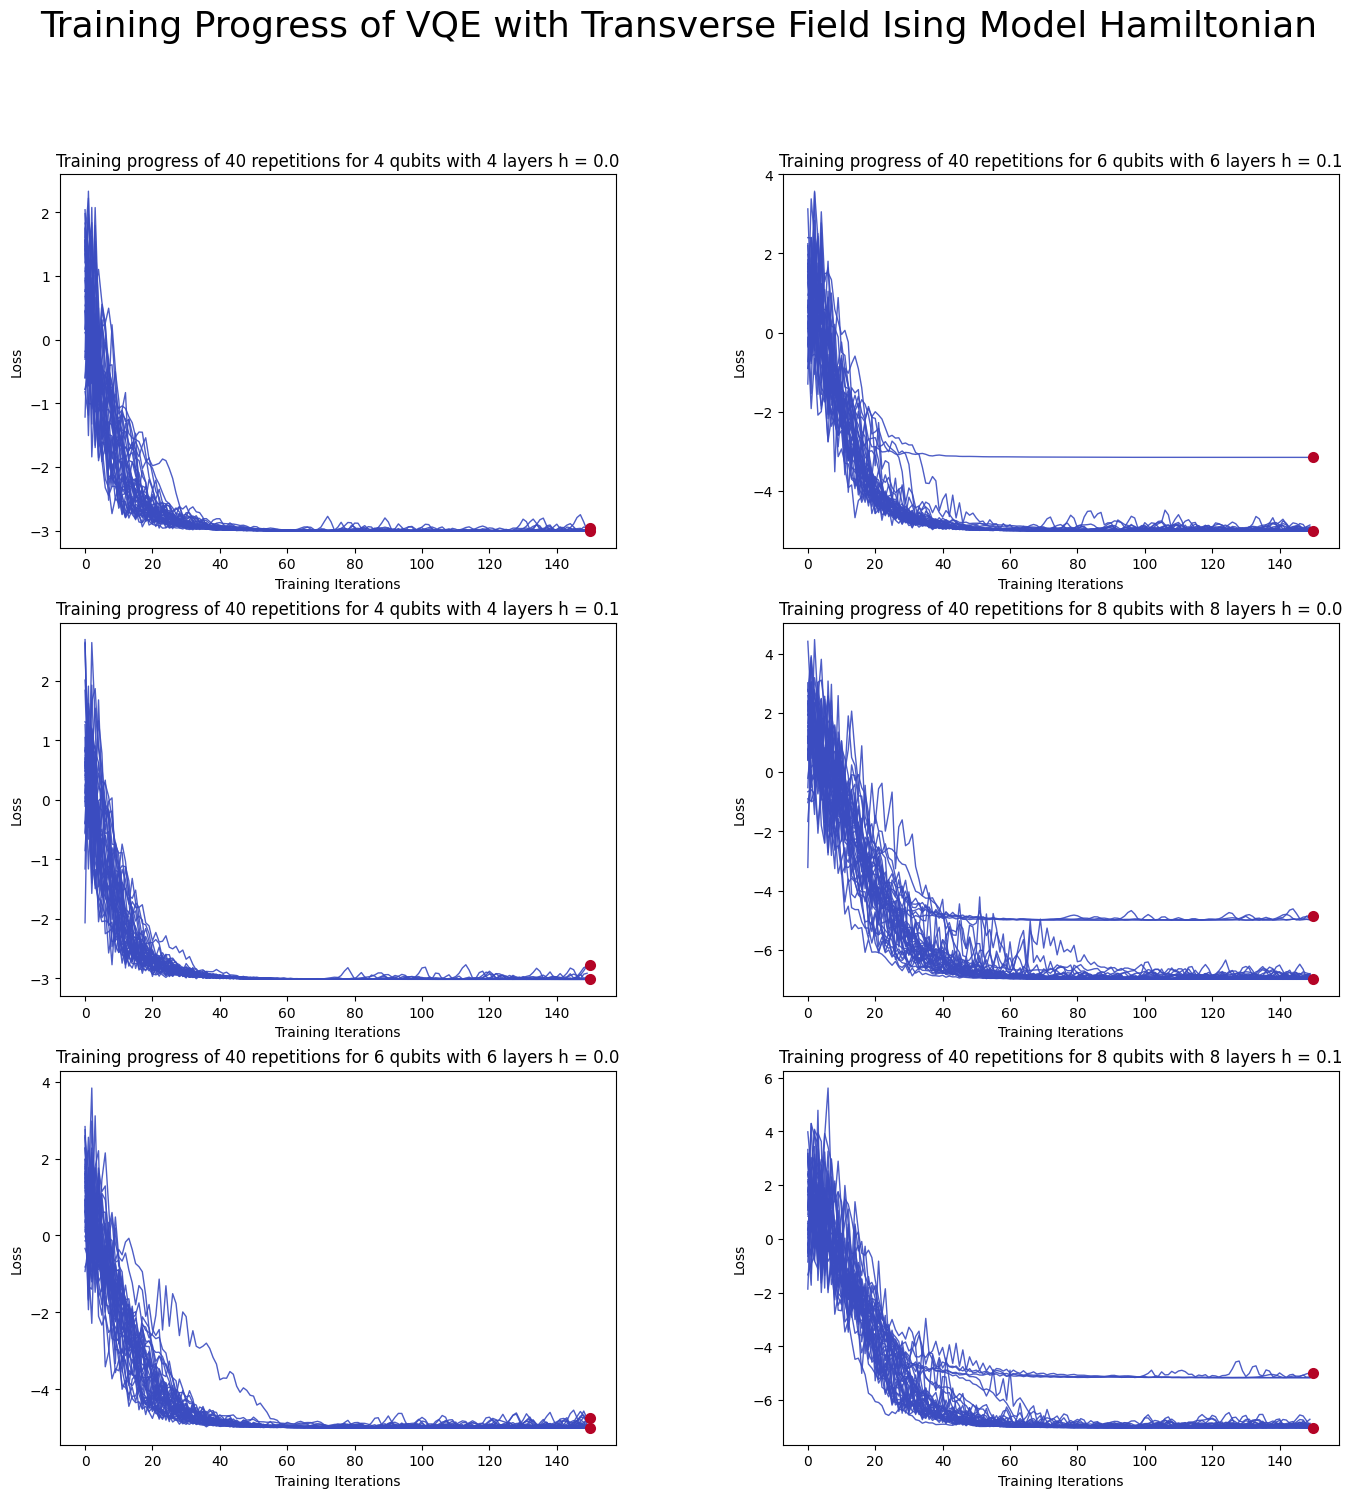

In [20]:
fig, axs = plt.subplots(3, 2, figsize=(16.5 ,16.5), gridspec_kw=dict(wspace=0.3))

fig.suptitle('Training Progress of VQE with Transverse Field Ising Model Hamiltonian', fontsize=26)

for column in range(2):

    for row in range(3):
        
        if column == 0:
            exp_ind = row
        else:
            exp_ind = row+3
            
            
        experiment = experiments[exp_ind]
        nqubits = experiment["qubits"]
        nlayers = experiment["layers"]
     
        axs[row,column].plot(experiment["all_costs"].T, linewidth=1.0, color=plt.get_cmap("coolwarm", 7)(0), alpha=0.9)

        #plt.title("Training Progress of " + experiment["repetitions"]) + " Repetitions")
        axs[row, column].set_ylabel("Loss")
        axs[row, column].set_xlabel("Training Iterations")
        #plt.ylim(loss_limits)
        axs[row, column].scatter([150, 150], experiment["all_costs"][[0, -1],-1], color=plt.get_cmap("coolwarm", 7)(6), linewidth=2, zorder=3)

        axs[row, column].set_title("Training progress of " + str(experiment["repetitions"]) + " repetitions for " + str(nqubits) + " qubits with " + str(nlayers) + " layers h = " + str(experiment["h"]))
        #cbar = get_colorbar_from_ax(axs[layers,qubits])

    #plt.title("Collection of " + str(len(whiches)) + " trajectories for " + str(experiments[0]["qubits"]) + " qubits, " + str(experiments[0]["layers"]) + " layer Ansatz")

    
#plt.savefig("MultiVQE_Training_Progress.pdf")
    
plt.show()
    
    

/Users/jorgegarciaponce/Desktop/Research/Yelin/Perceptron/DigitalComparison/digital_venv/lib/python3.8/site-packages/numpy/lib/histograms.py:839: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/jorgegarciaponce/Desktop/Research/Yelin/Perceptron/DigitalComparison/digital_venv/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6793: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


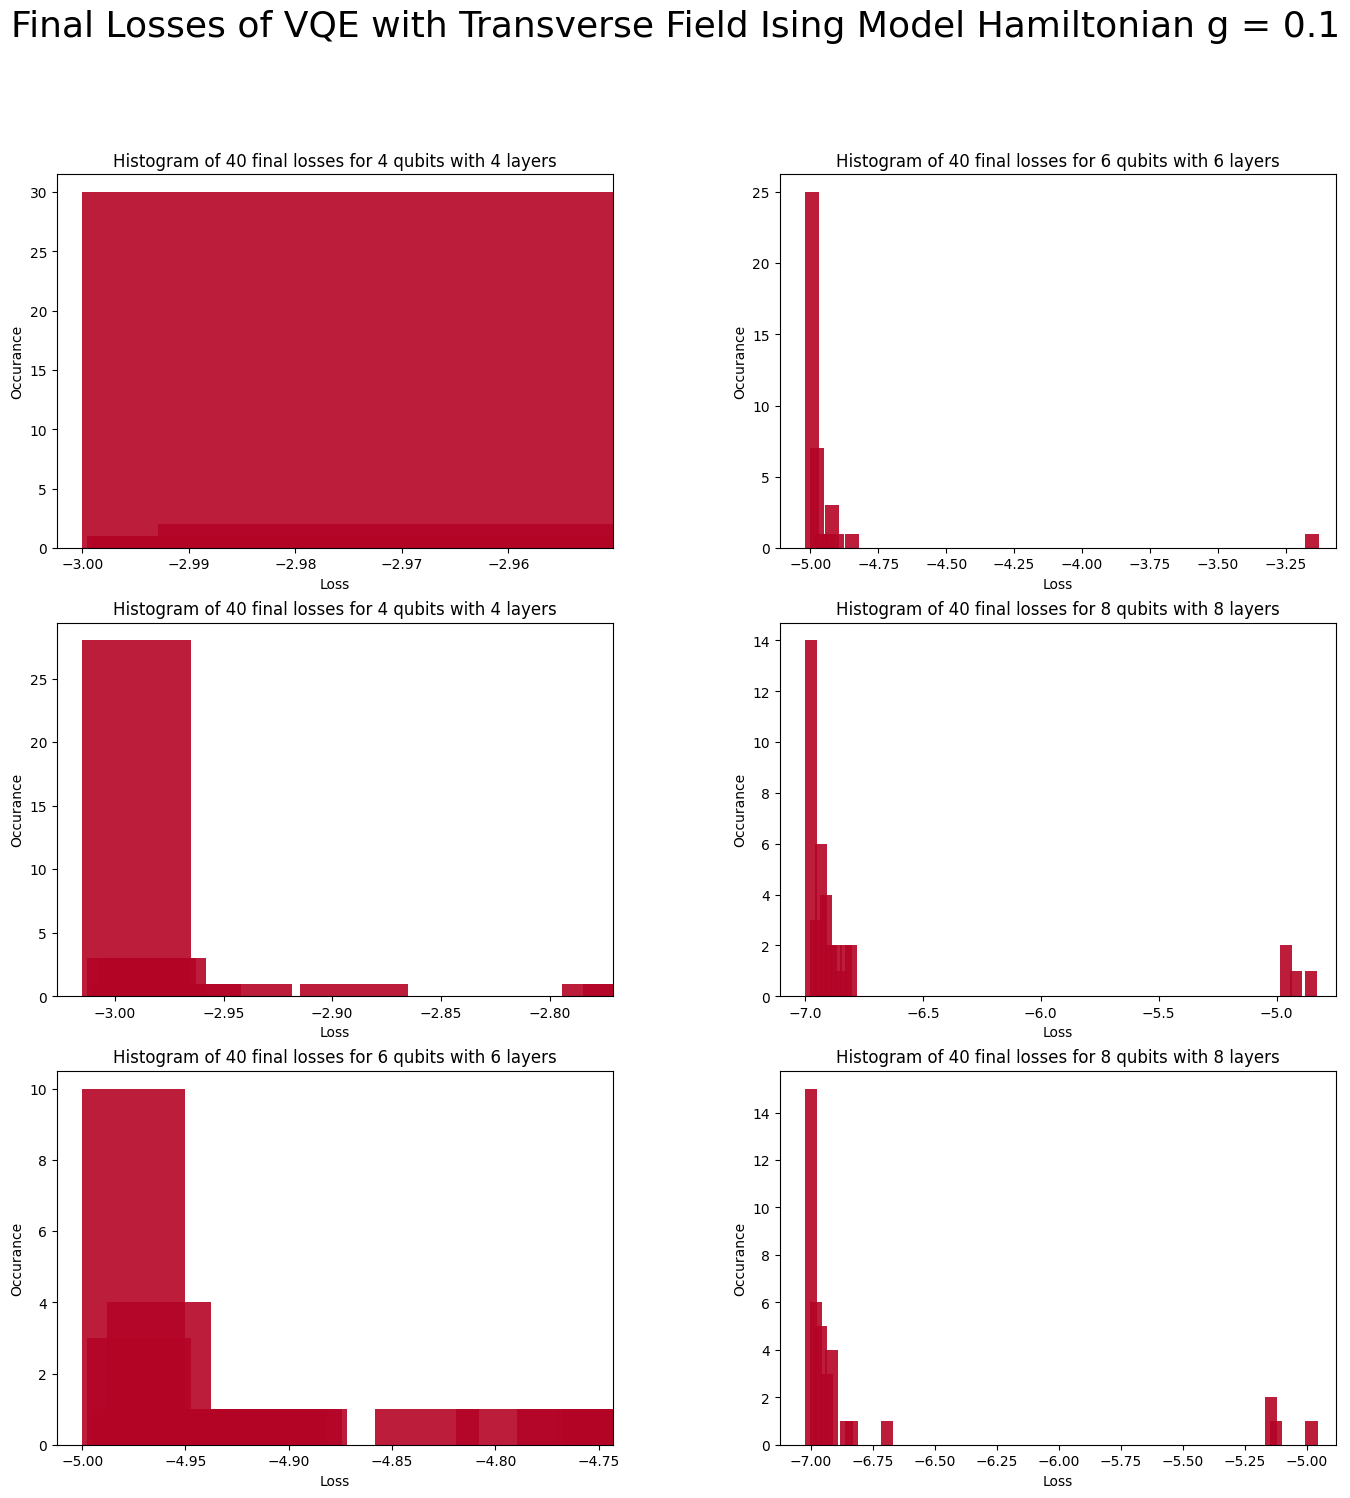

In [21]:
fig, axs = plt.subplots(3, 2, figsize=(16.5 ,16.5), gridspec_kw=dict(wspace=0.3))

fig.suptitle('Final Losses of VQE with Transverse Field Ising Model Hamiltonian g = 0.1', fontsize=26)

for qubits in range(2):

    for layers in range(3):
        
        if qubits == 0:
            exp_ind = layers
        else:
            exp_ind = layers+3
            
            
        experiment = experiments[exp_ind]
        nqubits = experiment["qubits"]
        nlayers = experiment["layers"]
     


        axs[layers,qubits].hist(experiment["all_costs"][:,-1], bins=100, width=0.05, align="mid", color=plt.get_cmap("coolwarm", 7)(6), alpha=0.9)
        #axs[layers,qubits].set_title("Histogram of " + experiment["repetitions"] + " final losses")
        axs[layers,qubits].set_xlabel("Loss")
        axs[layers,qubits].set_ylabel("Occurance")
        axs[layers,qubits].set_title("Histogram of " + str(experiment["repetitions"]) + " final losses for " + str(nqubits) + " qubits with " + str(nlayers) + " layers")
        #cbar = get_colorbar_from_ax(axs[layers,qubits])

    #plt.title("Collection of " + str(len(whiches)) + " trajectories for " + str(experiments[0]["qubits"]) + " qubits, " + str(experiments[0]["layers"]) + " layer Ansatz")

    
plt.savefig("MultiVQE_Final_Loss_Histograms.pdf")
    
plt.show()



# plt.hist(experiments[5]["all_costs"][:,-1], bins=100, width=0.05, align="mid", color=plt.get_cmap("coolwarm", 7)(6), alpha=0.9)
# plt.title("Histogram of " + str(experiments[5]["repetitions"]) + " final losses")
# plt.xlabel("Loss")
# plt.ylabel("Occurance")
# #plt.xlim(loss_limits)
# plt.show()

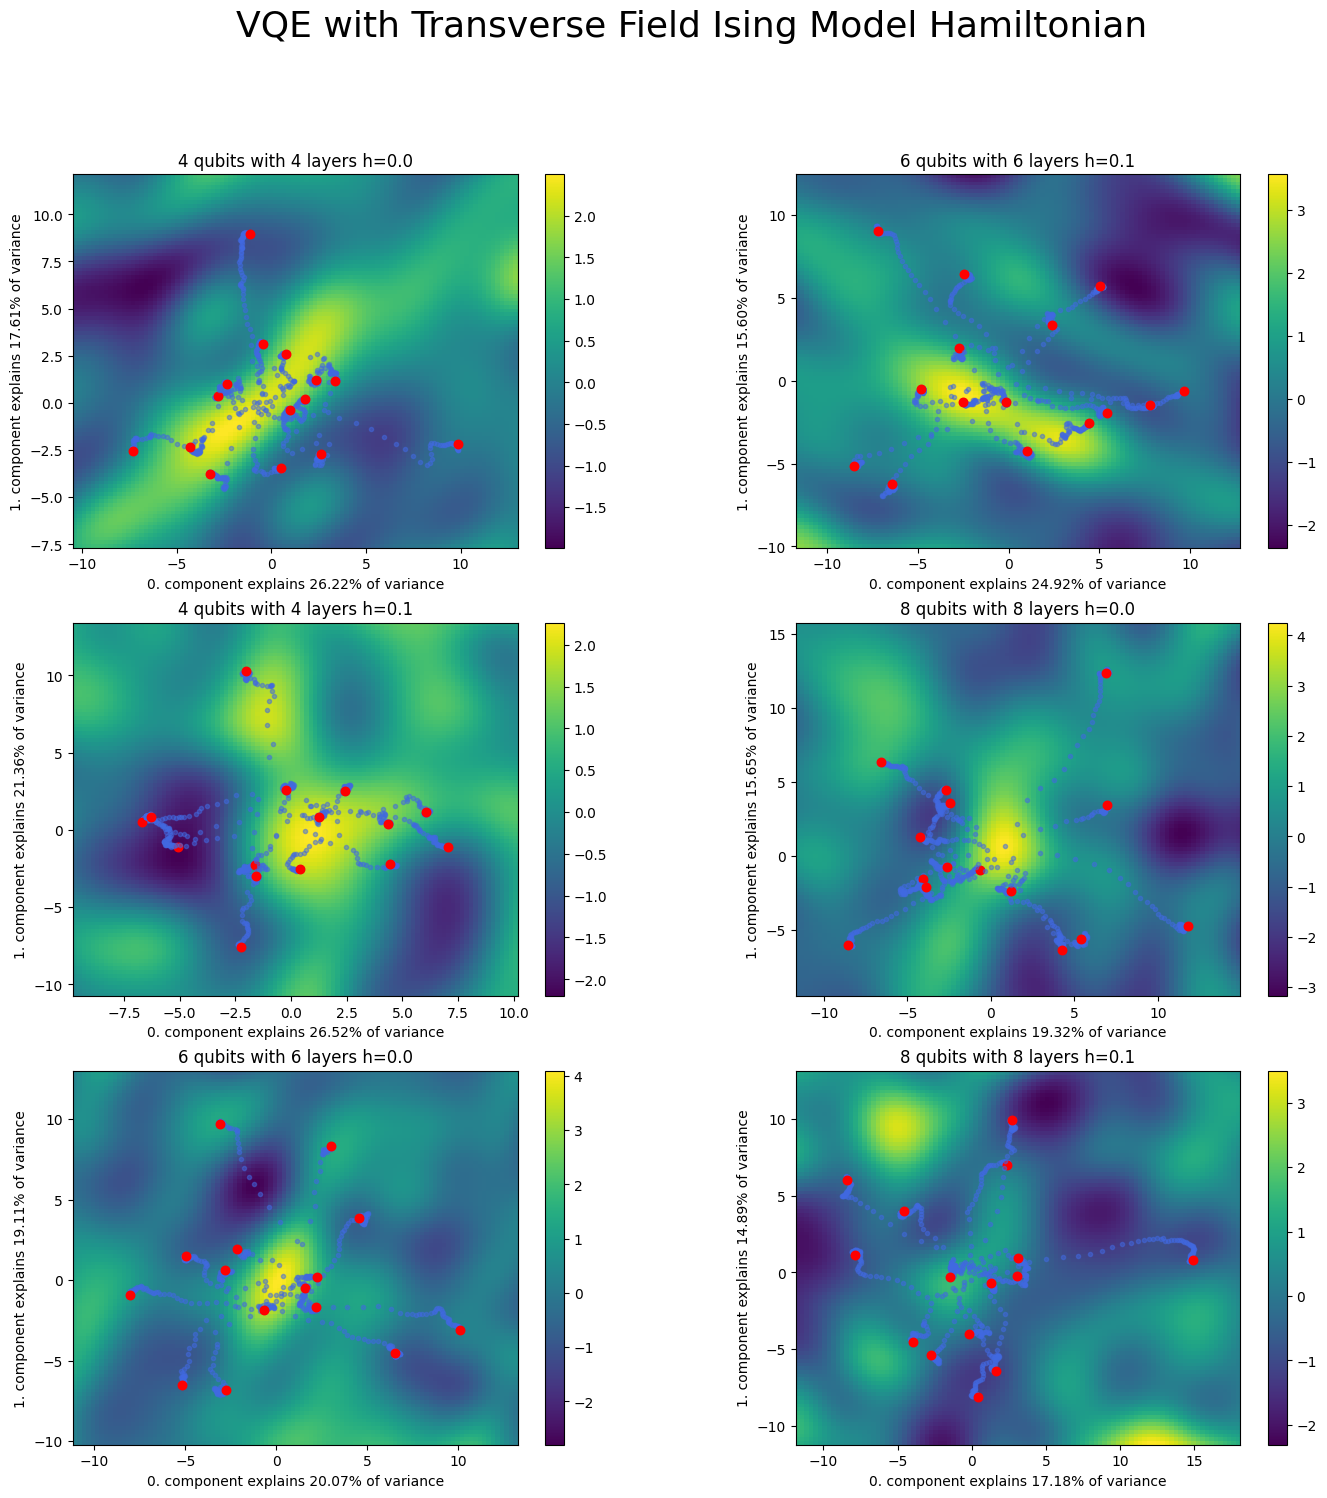

In [25]:
from orqviz.pca import get_pca, perform_2D_pca_scan, plot_pca_landscape, plot_scatter_points_on_pca
from orqviz.plot_utils import normalize_color_and_colorbar, get_colorbar_from_ax


whiches = np.append(np.arange(0,8), np.arange(-8,-1), axis=0)


fig, axs = plt.subplots(3, 2, figsize=(16.5 ,16.5), gridspec_kw=dict(wspace=0.3))

fig.suptitle('VQE with Transverse Field Ising Model Hamiltonian', fontsize=26)

for qubits in range(2):

    for layers in range(3):
        
        if qubits == 0:
            exp_ind = layers
        else:
            exp_ind = layers+3
            
            
        experiment = experiments[exp_ind]
        nqubits = experiment["qubits"]
        nlayers = experiment["layers"]
     
        #whiches = np.append(np.arange(0,8), np.arange(-8,-1), axis=0)
        #print(all_parameter_trajectories[[-2,-1]])
        pca = get_pca(np.concatenate([experiment["all_parameters"][which] for which in whiches], axis=0))
        scanpca_result = perform_2D_pca_scan(pca, experiment["loss_function"], n_steps_x=100, offset=3)


        plot_pca_landscape(scanpca_result, pca, fig=fig, ax=axs[layers,qubits])
        for which in whiches:
            plot_scatter_points_on_pca(experiment["all_parameters"][which], pca, color="royalblue", alpha=0.5, ax=axs[layers,qubits])
            plot_scatter_points_on_pca([experiment["all_final_parameters"][which]], pca, color="red", alpha=1., s=150, ax=axs[layers,qubits])

        #normalize_color_and_colorbar(fig, ax, 0., 1.3)
        axs[layers,qubits].set_title(str(nqubits) + " qubits with " + str(nlayers) + " layers h=" + str(experiment["h"]))
        cbar = get_colorbar_from_ax(axs[layers,qubits])

    #plt.title("Collection of " + str(len(whiches)) + " trajectories for " + str(experiments[0]["qubits"]) + " qubits, " + str(experiments[0]["layers"]) + " layer Ansatz")

    
plt.savefig("MultiVQE_PCA.pdf")
    
plt.show()

## Trying out ORVIZ's Hessian algorithm to see if it is feasible to use for this analysis

In [37]:
experiment = experiments[-1]

loss_function = experiment["loss_function"]
parameter_vector = experiment["all_final_parameters"][-1]

print(experiment["qubits"])


8


In [34]:
%%time

from orqviz.hessians import get_Hessian


hessian = get_Hessian(parameter_vector, loss_function)

CPU times: user 5.7 s, sys: 23.7 ms, total: 5.72 s
Wall time: 5.74 s


IT IS! We can analyze all our results with the exact hessian that ORQVIZ provides

In [40]:
from orqviz.hessians import get_Hessian_SPSA_approx, get_Hessian

# 4 Qubits h=0.0
experiment = experiments[-1]

for experiment in experiments:

    loss_function = experiment["loss_function"]
    all_final_costs = experiment["all_costs"][:,-1]

    hessians = []


    for i in range(len(experiment["all_final_parameters"])):
        
        parameter_vector = experiment["all_final_parameters"][i]
        cost = all_final_costs[i]

        hessian = get_Hessian(parameter_vector, loss_function)
        
        print(cost)
        #print(hessian_SPSA_approx.eigenvalues)
        print(hessian.eigenvalues)
        
        hessians.append({
            'hessian_matrix':hessian,
            'energy': cost
        })

    experiment["final_hessians"] = hessians


(-3.0000035762786865+2.2859909165617864e-07j)
[-2.89744708e+00 -2.58009231e+00 -2.20420401e+00 -1.81904407e+00
 -1.81241104e+00 -1.68103403e+00 -1.15314603e+00 -8.54957188e-01
 -4.44327344e-01 -3.37191600e-01 -2.85149902e-05 -1.22234211e-05
  2.46858480e-06  4.36701431e-05  5.42864707e-05  1.53967045e-01]
(-3.000002384185791+2.2933818399906158e-07j)
[-2.25317218e+00 -9.23731495e-01 -7.16773715e-01 -3.88488401e-01
 -1.79288548e-01 -1.21231277e-05 -6.43117610e-06 -1.17273966e-07
  1.02367064e-05  2.03152271e-05  7.38514015e-03  2.91131525e-01
  7.67641225e-01  1.13171964e+00  1.99970142e+00  2.15388209e+00]
(-3.0000011920928955-2.8874384838672995e-07j)
[-5.10635250e-01 -5.31026027e-02 -3.39776542e-02 -3.44203586e-05
 -8.65320511e-06 -6.13834814e-06  3.48849465e-06  1.59257950e-05
  1.88698642e-01  3.60676426e-01  4.61975046e-01  5.42108690e-01
  9.11973964e-01  1.37673153e+00  1.79969619e+00  1.96815073e+00]
(-3.0000009536743164-2.984524769544805e-07j)
[-9.47151228e-01 -5.70831159e-01 -2

In [41]:
hessians

[{'hessian_matrix': HessianEigenobject(params=array([ 5.6208630e+00, -3.0350933e+00,  2.2005901e+00, -1.5095249e+00,
         -9.3025392e-01, -1.1852878e+00,  1.6557280e+00, -2.3463516e-01,
         -4.3687099e-01,  1.5721941e+00, -2.9715075e+00,  1.5344135e+00,
         -4.2598433e+00, -1.6265060e+00, -3.5460356e-01, -1.4045995e+00,
          8.5092134e+00, -3.0804164e+00, -5.1672269e-02,  1.5351317e+00,
          1.4423507e+00, -2.7824500e+00,  1.5280716e+00, -8.2068592e-02,
         -1.1352105e+00, -8.4364573e-03, -1.8596456e+00, -2.0674603e+00,
          2.1320640e-01, -4.2716500e-01,  3.3574653e+00, -9.6615267e-01],
        dtype=float32), hessian_matrix=array([[ 1.90587044e+00, -3.38256359e-02, -1.19209290e-05, ...,
           5.96046448e-06,  5.96046448e-06,  1.19209290e-05],
         [-3.38256359e-02,  2.08960772e+00,  1.24961138e-01, ...,
          -1.19209290e-05,  0.00000000e+00,  1.19209290e-05],
         [-1.19209290e-05,  1.24961138e-01,  1.32150650e+00, ...,
           5

In [47]:
experiments[0]["final_hessians"]

[{'hessian_matrix': HessianEigenobject(params=array([-1.5674120e+00,  1.2743592e+00,  8.8332355e-01, -3.6180520e-04,
          7.8523642e-01,  1.5764624e+00,  8.3887100e-01,  1.1579539e+00,
          1.5741299e+00, -1.2458493e+00, -1.5593420e-01, -2.0346607e-04,
         -5.0133778e-05, -1.1333875e-02, -7.8534180e-01, -3.0088992e+00],
        dtype=float32), hessian_matrix=array([[-1.72659159e+00, -1.05082989e-02,  3.56435776e-03,
          -5.96046448e-06, -2.20894814e-02, -6.38419390e-01,
           4.52995300e-04,  0.00000000e+00, -9.27507877e-02,
          -2.38656998e-02,  2.09808350e-03,  5.96046448e-06,
           1.19209290e-05,  0.00000000e+00,  0.00000000e+00,
           1.78813934e-05],
         [-1.05082989e-02, -1.40664577e+00,  2.15554237e-01,
          -1.19209290e-05,  1.63155794e-01, -7.09295273e-04,
           2.75850296e-02, -1.19209290e-05,  1.84178352e-03,
          -7.03424215e-01,  1.27202272e-01, -1.19209290e-05,
          -5.96046448e-06, -5.96046448e-06,  0.00

In [62]:
for i in experiments[0]["final_hessians"]:
    print(i["hessian_matrix"].eigenvalues)

# experiments[0]["final_hessians"][0]["hessian_matrix"].eigenvalues

[-2.89744708e+00 -2.58009231e+00 -2.20420401e+00 -1.81904407e+00
 -1.81241104e+00 -1.68103403e+00 -1.15314603e+00 -8.54957188e-01
 -4.44327344e-01 -3.37191600e-01 -2.85149902e-05 -1.22234211e-05
  2.46858480e-06  4.36701431e-05  5.42864707e-05  1.53967045e-01]
[-2.25317218e+00 -9.23731495e-01 -7.16773715e-01 -3.88488401e-01
 -1.79288548e-01 -1.21231277e-05 -6.43117610e-06 -1.17273966e-07
  1.02367064e-05  2.03152271e-05  7.38514015e-03  2.91131525e-01
  7.67641225e-01  1.13171964e+00  1.99970142e+00  2.15388209e+00]
[-5.10635250e-01 -5.31026027e-02 -3.39776542e-02 -3.44203586e-05
 -8.65320511e-06 -6.13834814e-06  3.48849465e-06  1.59257950e-05
  1.88698642e-01  3.60676426e-01  4.61975046e-01  5.42108690e-01
  9.11973964e-01  1.37673153e+00  1.79969619e+00  1.96815073e+00]
[-9.47151228e-01 -5.70831159e-01 -2.86404962e-01 -3.83498672e-05
  9.40611894e-06  4.33856162e-05  6.18069448e-05  6.68022865e-05
  3.29876082e-01  4.57583418e-01  1.26879137e+00  1.42415956e+00
  1.73345850e+00  1.80

In [65]:
experiments[0]

{'qubits': 4,
 'layers': 4,
 'repetitions': 40,
 'h': 0.0,
 'all_parameters': array([[[-2.2822559e+00,  1.8548129e+00,  1.0362666e+00, ...,
          -7.9217382e-02,  1.0582898e-01, -5.9397554e-01],
         [-2.7822559e+00,  2.3548129e+00,  5.3626657e-01, ...,
           4.2078254e-01,  6.0582900e-01, -1.0939754e+00],
         [-2.9750037e+00,  2.2916365e+00,  7.6479691e-01, ...,
           7.1262729e-01,  5.5905569e-01, -7.4073392e-01],
         ...,
         [-1.5672349e+00,  1.2745702e+00,  8.8336760e-01, ...,
          -1.1392814e-02, -7.8523999e-01, -3.0089054e+00],
         [-1.5675795e+00,  1.2744671e+00,  8.8322526e-01, ...,
          -1.1125063e-02, -7.8523088e-01, -3.0089023e+00],
         [-1.5674120e+00,  1.2743592e+00,  8.8332355e-01, ...,
          -1.1333875e-02, -7.8534180e-01, -3.0088992e+00]],
 
        [[ 9.7419888e-01, -2.5568309e-01, -6.4082086e-01, ...,
          -1.5352658e+00,  2.3340039e+00,  1.9967498e+00],
         [ 4.7419888e-01, -7.5568306e-01, -1.1408209